In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import Bio.SeqUtils.MeltingTemp as mt

from dredFISH.Utils.__init__plots import *

In [2]:
def recalc_tm(seq, fmd=0, Na=1e-5, dnac1=0, dnac2=0):
    """
    """
    res = mt.Tm_NN(seq, Na=Na, dnac1=dnac1, dnac2=dnac2)
    res = mt.chem_correction(res, fmd=fmd)
    return res
    
def get_gc(seq):
    """
    """
    return (seq.count('G') + seq.count('C'))/len(seq)

In [3]:
def diagnostic_panels(dfnew):
    """
    """
    fig, axs = plt.subplots(2, 3, figsize=(3*5,2*4))
    ax = axs[0,0]
    sns.scatterplot(data=dfnew, x='onscore', y='offscore', edgecolor='none', s=5, ax=ax,) 
    ax = axs[0,1]
    sns.histplot(dfnew['onscore'],  ax=ax, bins=100)
    ax.set_yscale('log')
    ax = axs[0,2]
    sns.histplot(np.log10(dfnew['offscore']+1), ax=ax, bins=100)
    ax.set_yscale('log')
    ax.set_xlabel('log10(offscore+1)')
    ax = axs[1,0]
    sns.histplot(dfnew['prob'], bins=100, ax=ax)
    ax = axs[1,1]
    sns.histplot(dfnew['maxkmer'], bins=20, ax=ax)
    ax.set_yscale('log')
    ax = axs[1,2]
    sns.scatterplot(data=dfnew, x='tm', y='gc', edgecolor='none', s=5, ax=ax) 
    ax.set_xticks([37, 40, 45, 50, 52])
    fig.tight_layout()

In [4]:
ddir = "/bigstore/GeneralStorage/fangming/projects/dredfish/packages/PaintSHOP_pipeline/test12_skiprules/" 
f = os.path.join(ddir, "pipeline_output/03_output_files/03_rna_probes_iso/mm10_iso_newBalance.tsv")
header=[
    'chrom', 'start', 'end', # one based?
    'seq', 
    'tm', 
    'onscore',  # 0-100
    'offscore', # 0-10,000
    'repeat',
    'prob',
    'maxkmer',
    'strand',
    'gname',
    'transcripts',
]

df = pd.read_csv(f, sep="\t", header=None)
df.columns = header
df['len'] = df['end']-df['start']+1
df['gc'] = df['seq'].apply(get_gc) 
df

,chrom,start,end,seq,tm,onscore,offscore,repeat,prob,maxkmer,strand,gname,transcripts,len,gc
0,chr1,3214521,3214550,TGACCAAGGACACCGAAAACAGAAAGCGGG,42.59,99.052,0.000,0,0.502,0,+,Xkr4,1,30,0.533333
1,chr1,3214634,3214663,AGCTGATGGAGTGGTAAGCCCTCAAGCAGT,42.83,98.987,0.000,0,0.279,0,+,Xkr4,1,30,0.533333
2,chr1,3214882,3214911,ATTTGGCACTCGAAAGATGTGGCACGTGGT,42.67,100.000,0.000,0,0.192,0,+,Xkr4,1,30,0.500000
3,chr1,3214924,3214953,ACCTGCTGACCCATGTCATTCTGCACCTGG,43.76,100.000,0.000,0,0.277,2,+,Xkr4,1,30,0.566667
4,chr1,3214993,3215022,TAGTCCCTGTTCCTCTCCTGTGGCTCTGTG,42.13,99.877,0.000,0,0.525,2,+,Xkr4,1,30,0.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861485,chrY,90839135,90839164,CCTGTGCCTCAGCGCCACAGACTGCAGAAG,45.82,99.001,198.002,0,0.219,4,+,G530011O06Rik,1,30,0.633333
861486,chrY,90839179,90839208,ACGAGGGACGGGAAGAGAGTATTGCCGATG,42.68,98.736,190.012,0,0.200,2,+,G530011O06Rik,1,30,0.566667
861487,chrY,90839301,90839330,ATCACACCAGACAGGTGCCTCAGAGACACA,42.46,100.000,179.896,0,0.133,3,+,G530011O06Rik,1,30,0.533333
861488,chrY,90839344,90839373,AGTCCACAGTGAGATTGGATTGCAGAGCGC,42.32,96.398,192.796,0,0.281,4,+,G530011O06Rik,1,30,0.533333


In [5]:
assert np.all(df['len'] == 30)

dfnew = df.copy()
print("Raw", f"{len(dfnew):,}")

cond = dfnew['repeat']==0
dfnew = dfnew[cond]
print("Repeat regions removed", f"{len(dfnew):,}")

dfnew2 = dfnew.copy()
cond = dfnew2['offscore']<50
dfnew2 = dfnew2[cond]
print("Offscore filtered", f"{len(dfnew2):,}")

cond = dfnew2['onscore']>97
dfnew2 = dfnew2[cond]
print("Onscore filtered", f"{len(dfnew2):,}")

cond = dfnew2['maxkmer']<=10
dfnew2 = dfnew2[cond]
print("Max Kmer filtered", f"{len(dfnew2):,}")

cond = dfnew2['prob']<=0.5
dfnew2 = dfnew2[cond]
print("Secondary prob filtered", f"{len(dfnew2):,}")

Raw 861,490
Repeat regions removed 811,566
Offscore filtered 731,804
Onscore filtered 679,957
Max Kmer filtered 675,713
Secondary prob filtered 664,845


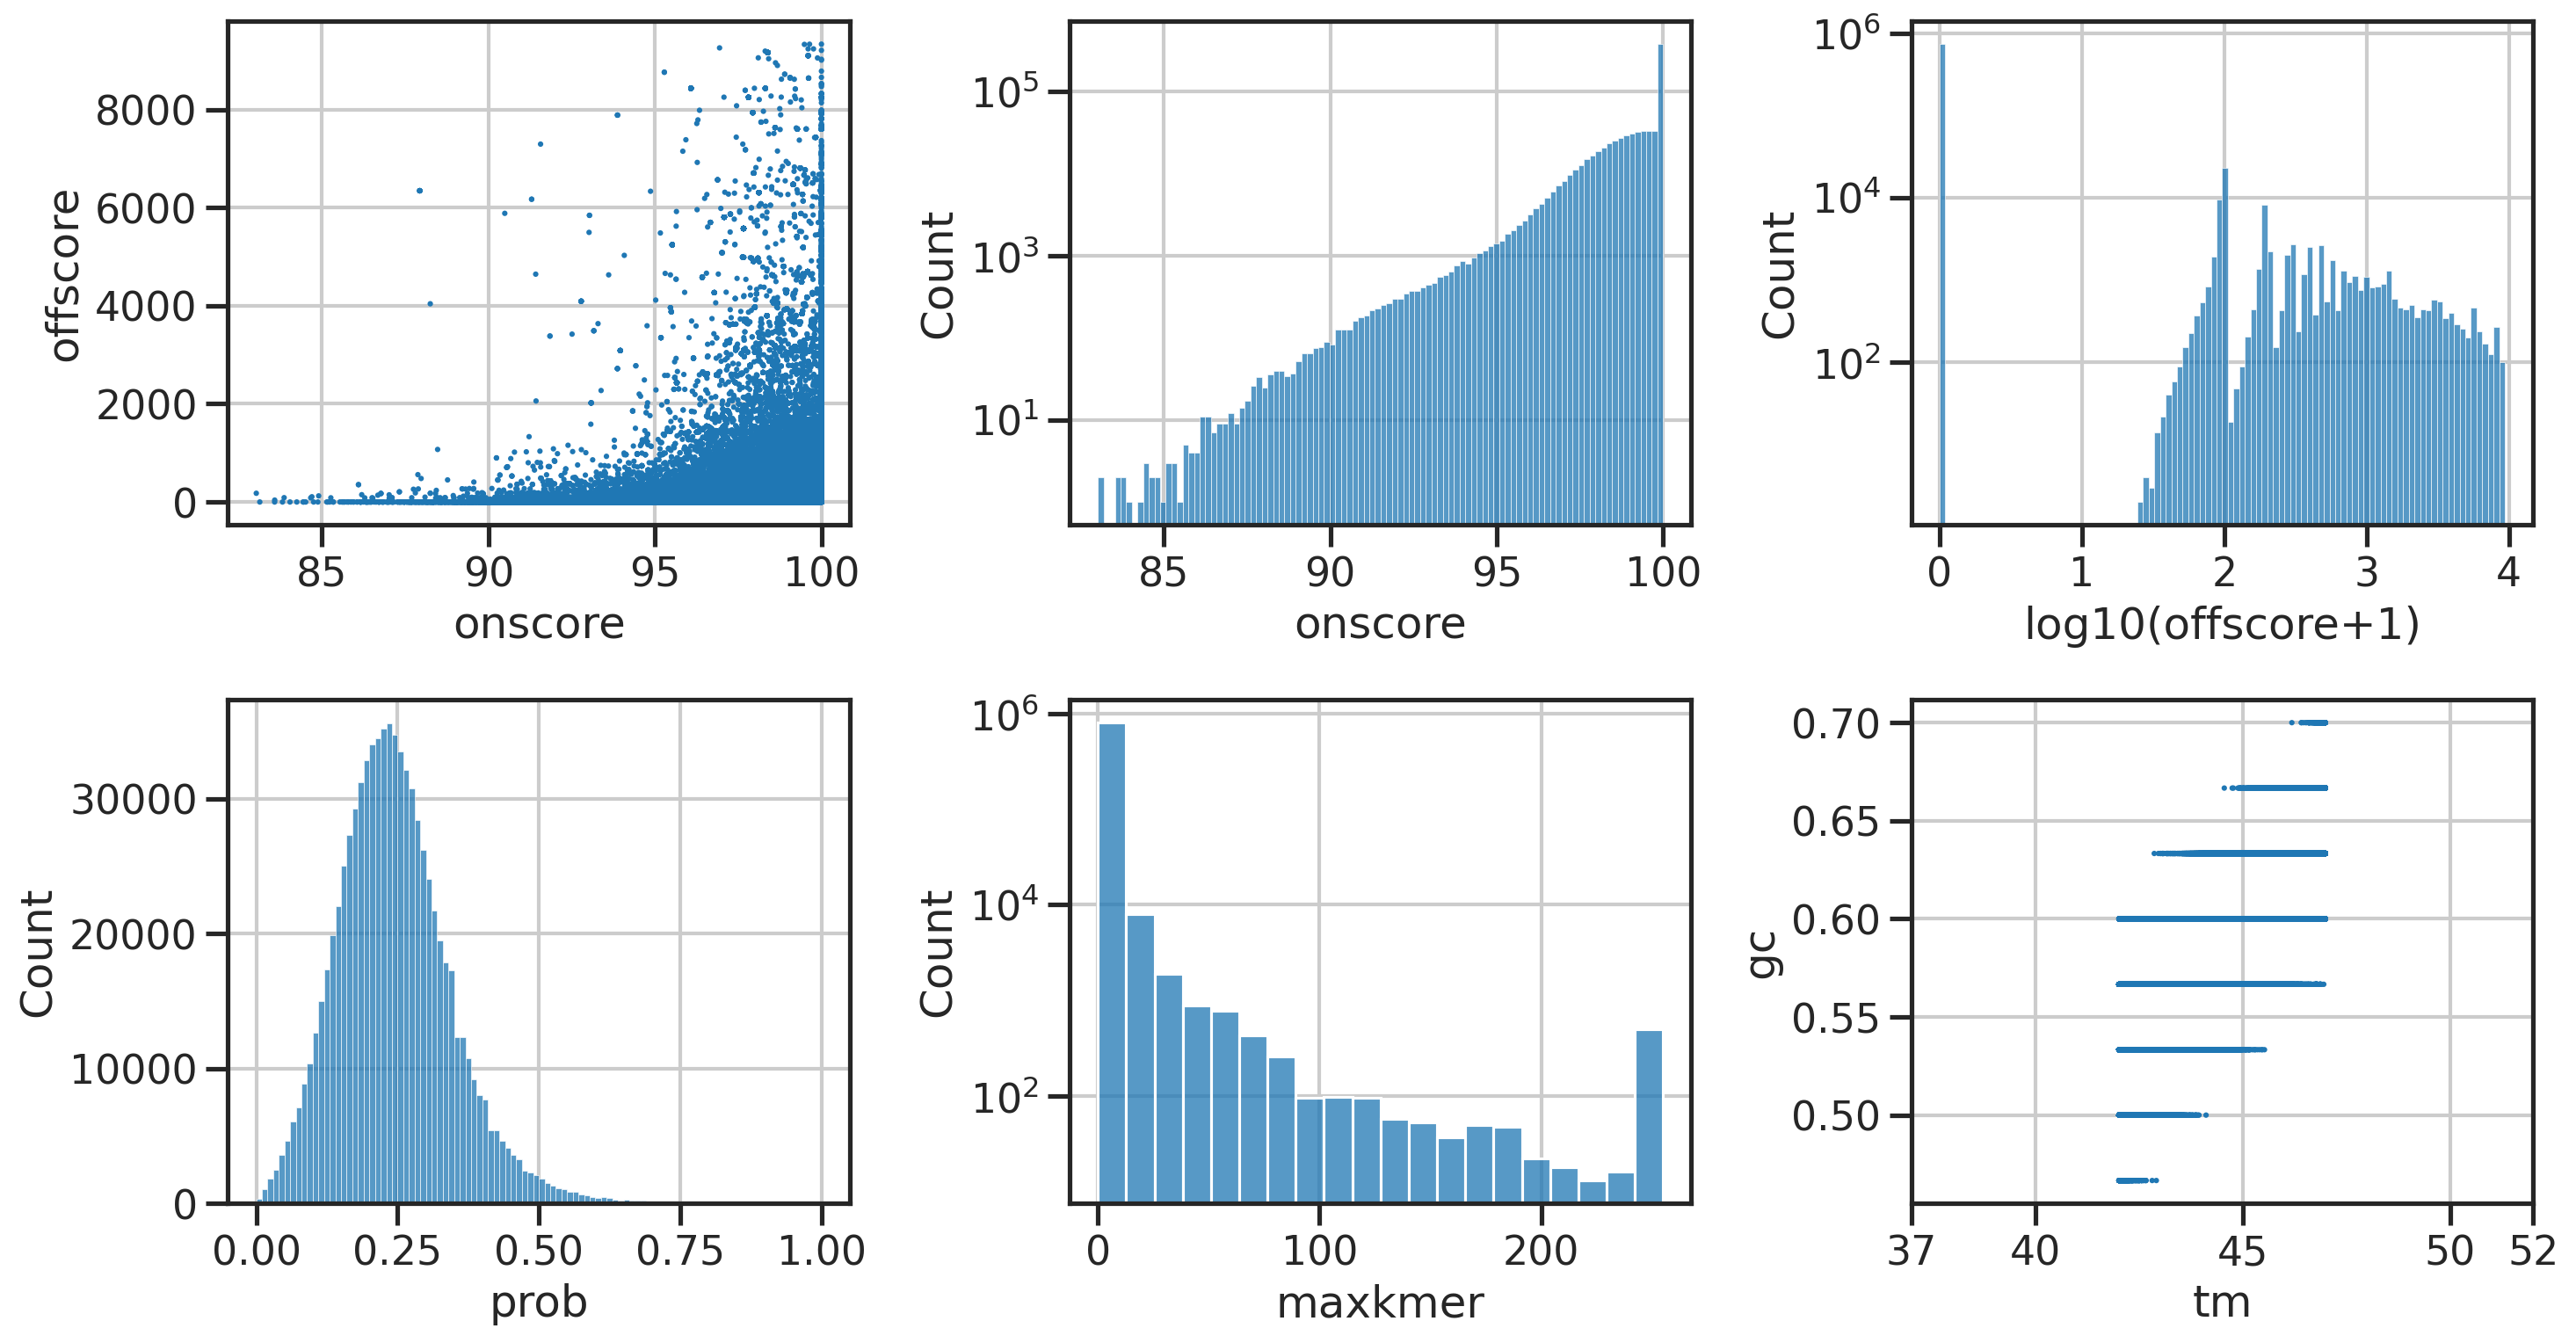

In [6]:
diagnostic_panels(dfnew)

In [7]:
dfnew2 = dfnew.copy()
cond = dfnew2['offscore']<50
dfnew2 = dfnew2[cond]
print(dfnew2.shape)

cond = dfnew2['onscore']>97
dfnew2 = dfnew2[cond]
print(dfnew2.shape)

cond = dfnew2['maxkmer']<=10
dfnew2 = dfnew2[cond]
print(dfnew2.shape)

cond = dfnew2['prob']<=0.5
dfnew2 = dfnew2[cond]
print(dfnew2.shape)

(731804, 15)
(679957, 15)
(675713, 15)
(664845, 15)


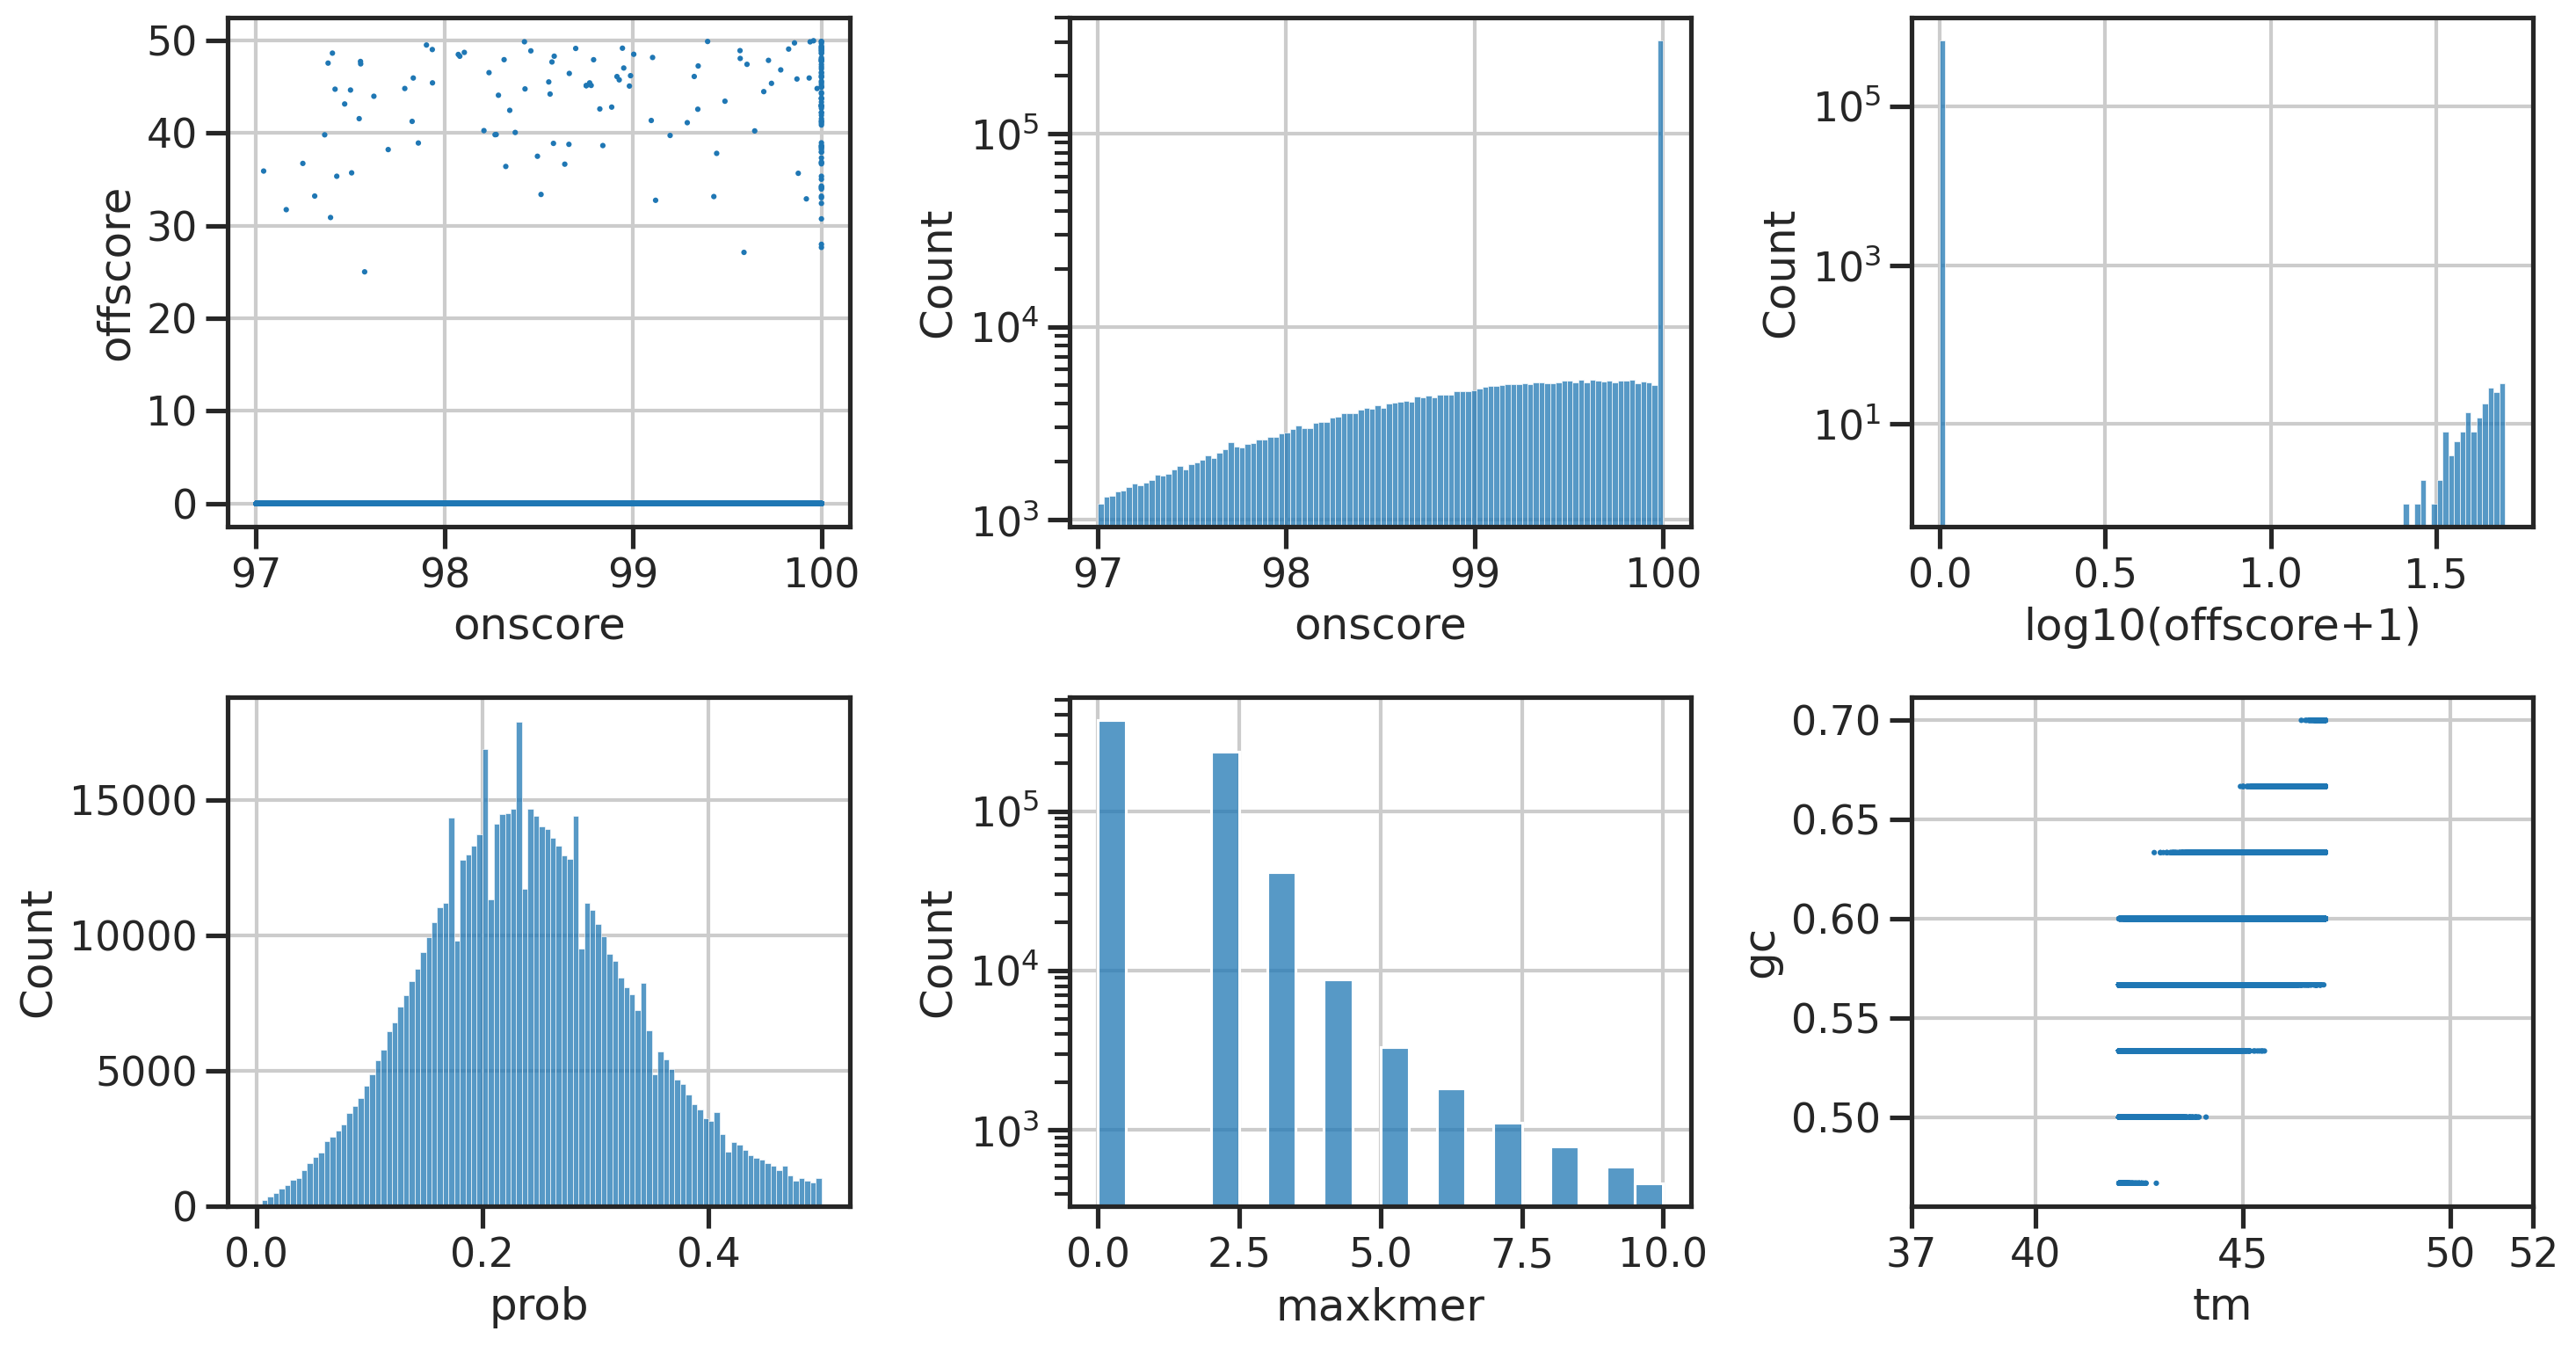

In [8]:
diagnostic_panels(dfnew2)

In [9]:
gene_cnstrnts = df.groupby('gname').size()
gene_cnstrnts_new = dfnew2.groupby('gname').size()# .reindex(gene_constraints.index)
cnstrnts = pd.DataFrame(gene_cnstrnts)
cnstrnts = cnstrnts.join(pd.DataFrame(gene_cnstrnts_new).rename(columns={0:1}))
cnstrnts = cnstrnts.fillna(0).astype(int)
cnstrnts

,0,1
gname,,
0610005C13Rik,17,16
0610009B22Rik,6,5
0610009E02Rik,7,7
0610009L18Rik,10,10
0610010F05Rik,11,11
...,...,...
Zyx,37,31
Zzef1,190,169
Zzz3,54,27


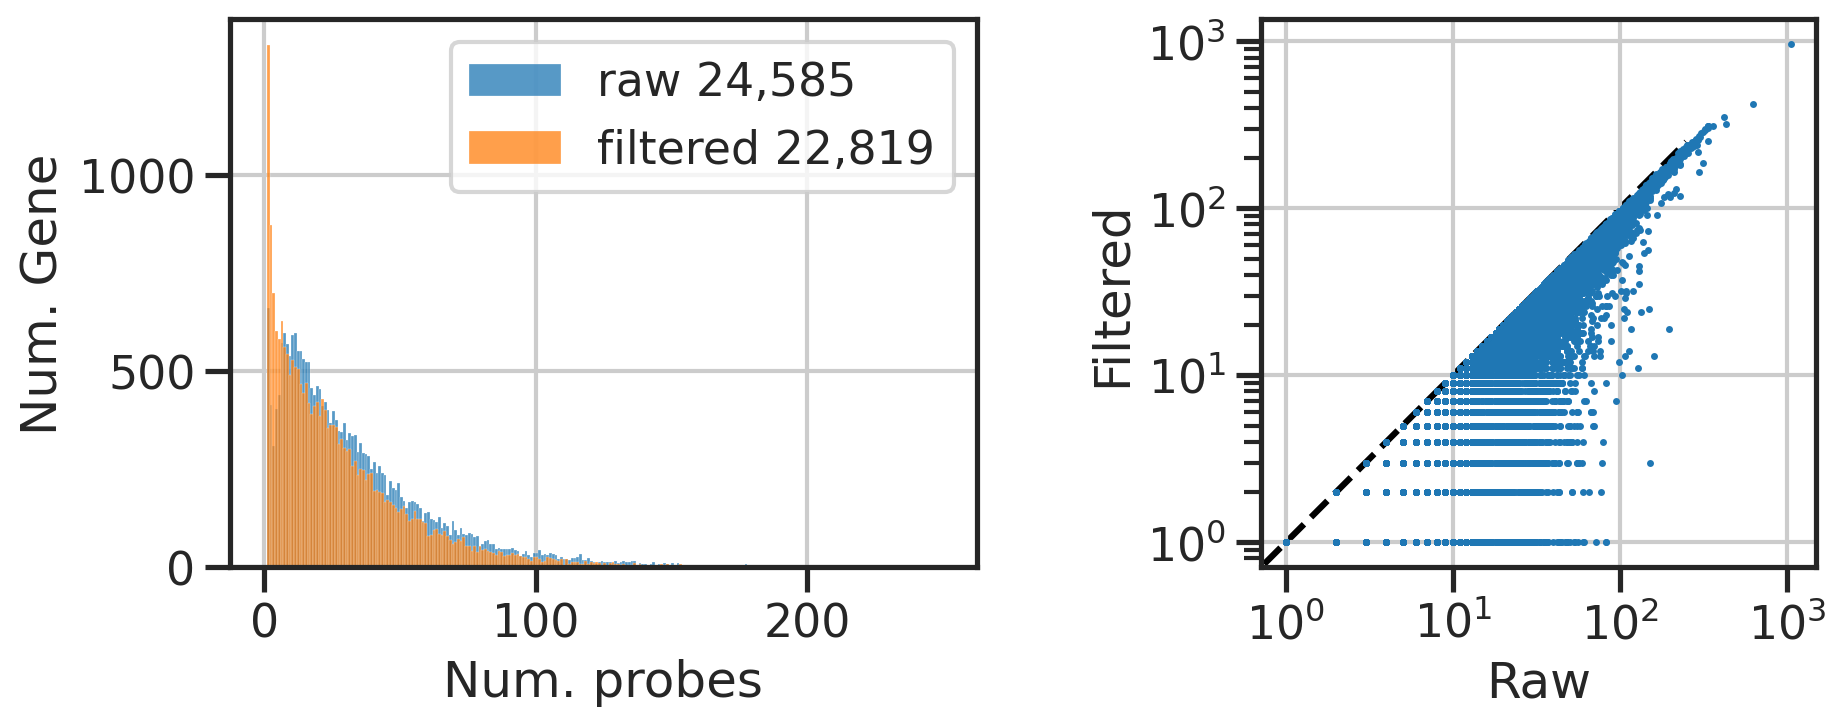

In [10]:
fig, axs = plt.subplots(1,2,figsize=(2*5,1*4))
ax = axs[0]
sns.histplot(np.sort(gene_cnstrnts),     color='C0', bins=np.linspace(0,250,251), ax=ax, label=f'raw {len(gene_cnstrnts):,}')
sns.histplot(np.sort(gene_cnstrnts_new), color='C1', bins=np.linspace(0,250,251), ax=ax, label=f'filtered {len(gene_cnstrnts_new):,}')
ax.set_ylabel('Num. Gene')
ax.set_xlabel('Num. probes')
ax.legend()

ax = axs[1]
ax.scatter(cnstrnts[0], cnstrnts[1], s=1)
ax.plot([0,250], [0,250], '--k', zorder=0)
ax.set_aspect('equal')
ax.set_xlabel('Raw')
ax.set_ylabel('Filtered')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([1,10,100,1000])
ax.set_yticks([1,10,100,1000])
fig.tight_layout()
plt.show()

In [11]:
cnstrnts.sort_values(0, ascending=False)

,0,1
gname,,
Ttn,1055,960
Kcnq1ot1,624,422
Obscn,429,321
Kmt2d,421,353
Bsn,359,313
...,...,...
Mir7017,1,0
Mir7016,1,1
Mir7015,1,1


Gene Ttn
Transcript (Including UTRs)
   Position: mm10 chr2:76,703,980-76,982,455 Size: 278,476 Total Exon Count: 347 Strand: -
Coding Region
   Position: mm10 chr2:76,705,031-76,980,182 Size: 275,152 Coding Exon Count: 346 

# recalculate Tm

In [12]:
dfviz = df.iloc[:10000].copy()
dfviz['dfttm'] = dfviz['seq'].apply(lambda x: recalc_tm(x, fmd=50, Na=390, dnac1=25, dnac2=25))
dfviz['ourtm'] = dfviz['seq'].apply(lambda x: recalc_tm(x, fmd=30, Na=300, dnac1=2,  dnac2=0.001))
dfviz['mattm'] = dfviz['seq'].apply(lambda x: recalc_tm(x, fmd=0,  Na=300, dnac1=2,  dnac2=2)) 
dfviz

,chrom,start,end,seq,tm,onscore,offscore,repeat,prob,maxkmer,strand,gname,transcripts,len,gc,dfttm,ourtm,mattm
0,chr1,3214521,3214550,TGACCAAGGACACCGAAAACAGAAAGCGGG,42.59,99.052,0.0,0,0.502,0,+,Xkr4,1,30,0.533333,42.589093,52.361577,71.179513
1,chr1,3214634,3214663,AGCTGATGGAGTGGTAAGCCCTCAAGCAGT,42.83,98.987,0.0,0,0.279,0,+,Xkr4,1,30,0.533333,42.826516,52.513870,71.314019
2,chr1,3214882,3214911,ATTTGGCACTCGAAAGATGTGGCACGTGGT,42.67,100.000,0.0,0,0.192,0,+,Xkr4,1,30,0.500000,42.665785,52.431509,71.248030
3,chr1,3214924,3214953,ACCTGCTGACCCATGTCATTCTGCACCTGG,43.76,100.000,0.0,0,0.277,2,+,Xkr4,1,30,0.566667,43.756240,53.467755,72.272928
4,chr1,3214993,3215022,TAGTCCCTGTTCCTCTCCTGTGGCTCTGTG,42.13,99.877,0.0,0,0.525,2,+,Xkr4,1,30,0.566667,42.133550,51.838190,70.641965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,chr1,59482530,59482559,ATACGCACGTCCCCTAAACCGAGCCAGGCC,46.55,100.000,0.0,0,0.370,0,-,Fzd7,1,30,0.633333,46.552977,56.289662,75.100030
9996,chr1,59482568,59482597,AAGTTTGCCCAAGTTTCTCGAGCCCCGGGC,46.05,100.000,0.0,0,0.213,0,-,Fzd7,1,30,0.600000,46.052266,55.779468,74.587867
9997,chr1,59482598,59482627,CGAGCAACAAGCTTCTCCGGTTACCCTTCA,42.05,100.000,0.0,0,0.087,0,-,Fzd7,1,30,0.533333,42.046188,51.826021,70.645504
9998,chr1,59482630,59482659,GAGACGTAACGGTGCGGCTTTCTCTGCGGC,45.94,96.654,0.0,0,0.233,0,-,Fzd7,1,30,0.633333,45.943911,55.798440,74.633453


Text(0, 0.5, 'our setting TM')

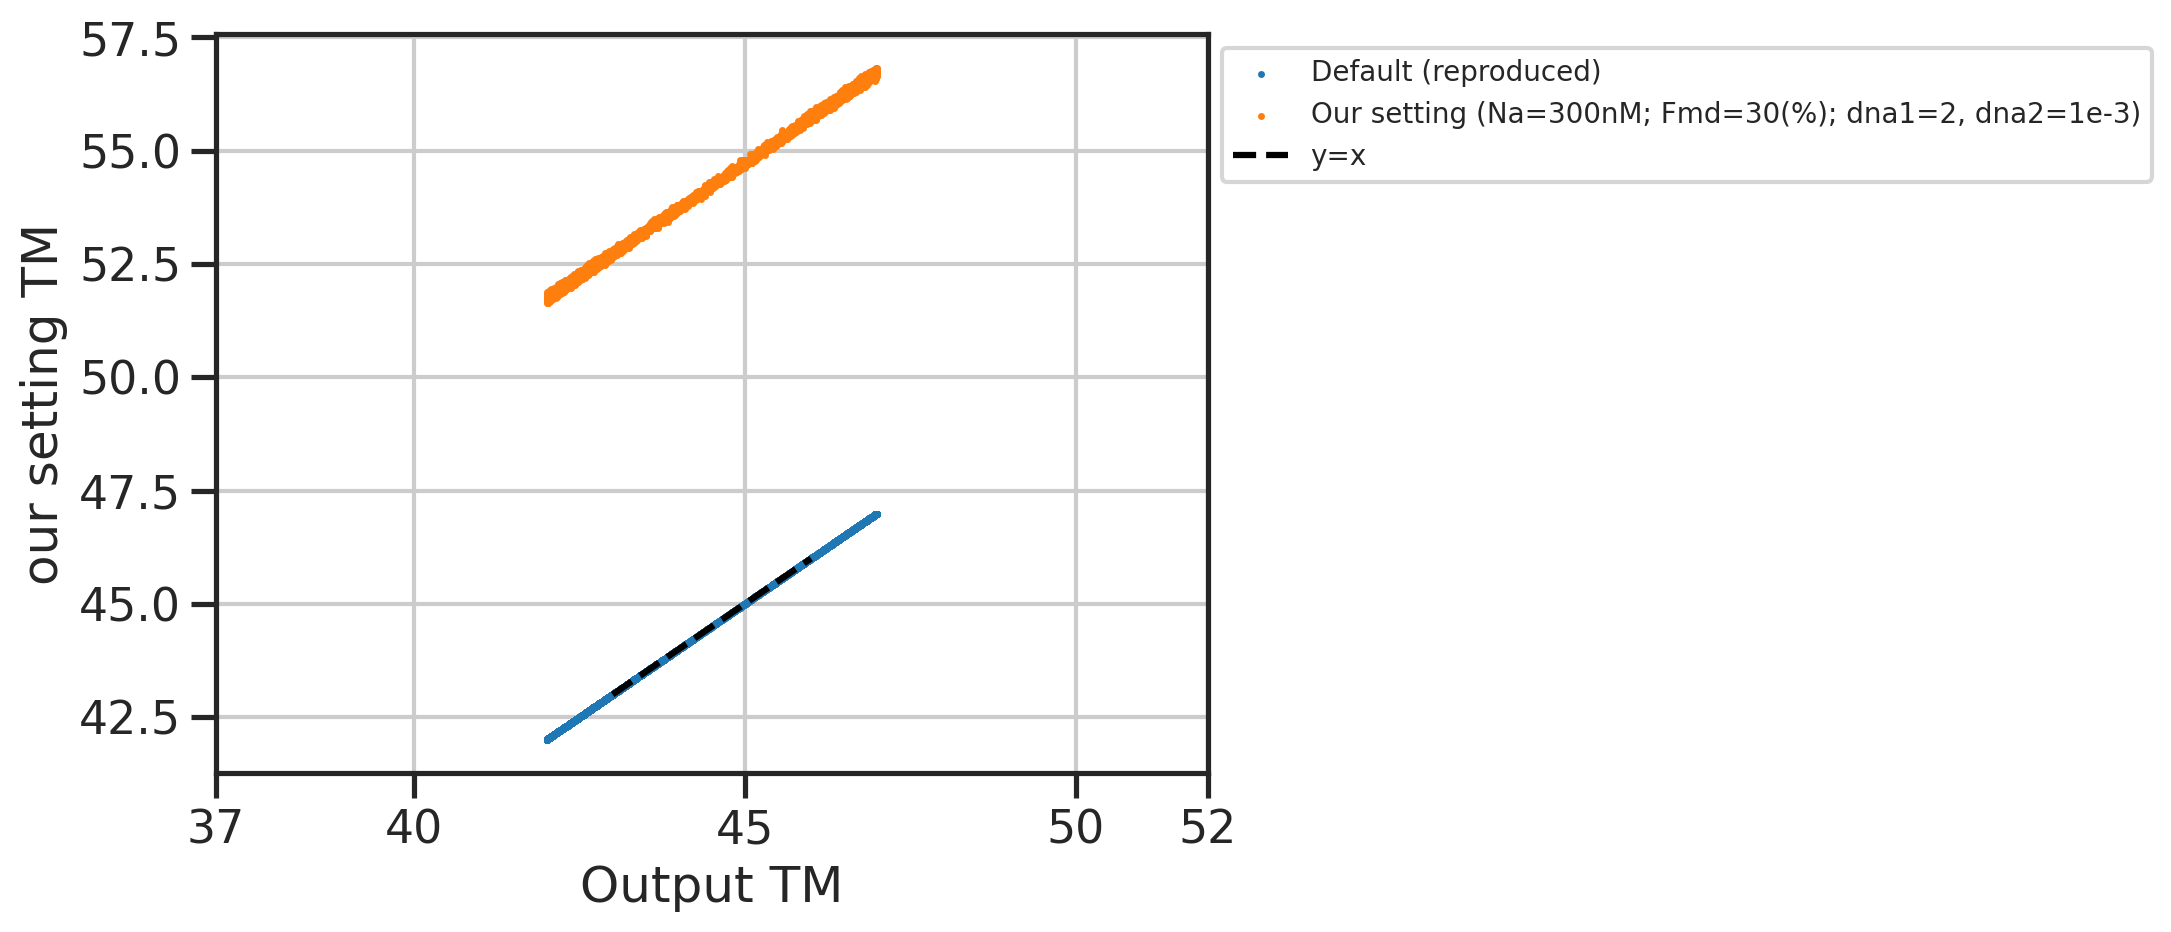

In [13]:
plt.scatter(dfviz['tm'].values, 
            dfviz['dfttm'].values,
            s=1,
            label="Default (reproduced)",
            ) 
plt.scatter(dfviz['tm'].values, 
            dfviz['ourtm'].values,
            s=1,
            label="Our setting (Na=300nM; Fmd=30(%); dna1=2, dna2=1e-3)",
            ) 
plt.plot([43,46], [43,46], '--k', label='y=x')
plt.xticks([37, 40, 45, 50, 52])
plt.legend(bbox_to_anchor=(1,1), fontsize=10)
plt.xlabel("Output TM")
plt.ylabel("our setting TM")

Text(0, 0.5, 'Diff')

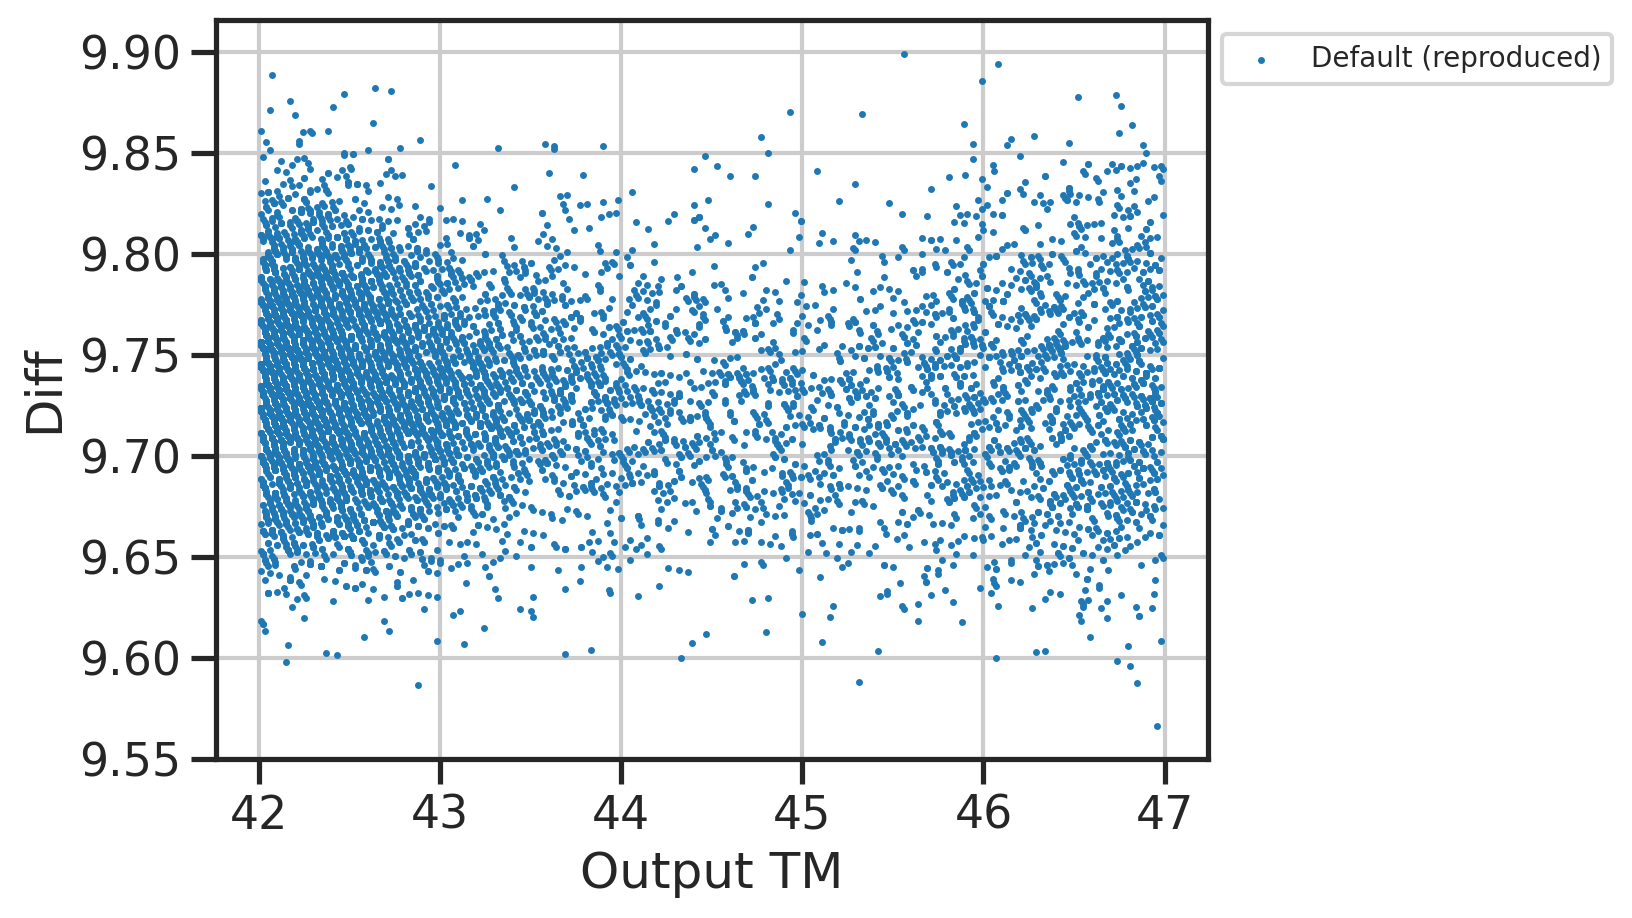

In [14]:
plt.scatter(dfviz['tm'].values, 
            dfviz['ourtm'].values - dfviz['dfttm'].values,
            s=1,
            label="Default (reproduced)",
            ) 
plt.legend(bbox_to_anchor=(1,1), fontsize=10)
plt.xlabel("Output TM")
plt.ylabel("Diff")

# get gene annotation -- how much exonic regions were used by the probes?

In [15]:
f = "/bigstore/GeneralStorage/fangming/projects/dredfish/packages/PaintSHOP_pipeline/test2/data/num30mer_estimate.csv"
upp = pd.read_csv(f, index_col=0)
upp

,len,num30mer,num30mer_cont
gene,,,
0610005C13Rik,1122,34,37
0610009B22Rik,795,25,26
0610009E02Rik,1974,63,65
0610009L18Rik,619,20,20
0610010F05Rik,5020,156,167
...,...,...,...
Zyx,4504,144,150
Zzef1,11150,346,371
Zzz3,7909,255,263


In [16]:
resall = upp.join(cnstrnts).fillna(0).astype(int)
resall

,len,num30mer,num30mer_cont,0,1
gene,,,,,
0610005C13Rik,1122,34,37,17,16
0610009B22Rik,795,25,26,6,5
0610009E02Rik,1974,63,65,7,7
0610009L18Rik,619,20,20,10,10
0610010F05Rik,5020,156,167,11,11
...,...,...,...,...,...
Zyx,4504,144,150,37,31
Zzef1,11150,346,371,190,169
Zzz3,7909,255,263,54,27


/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


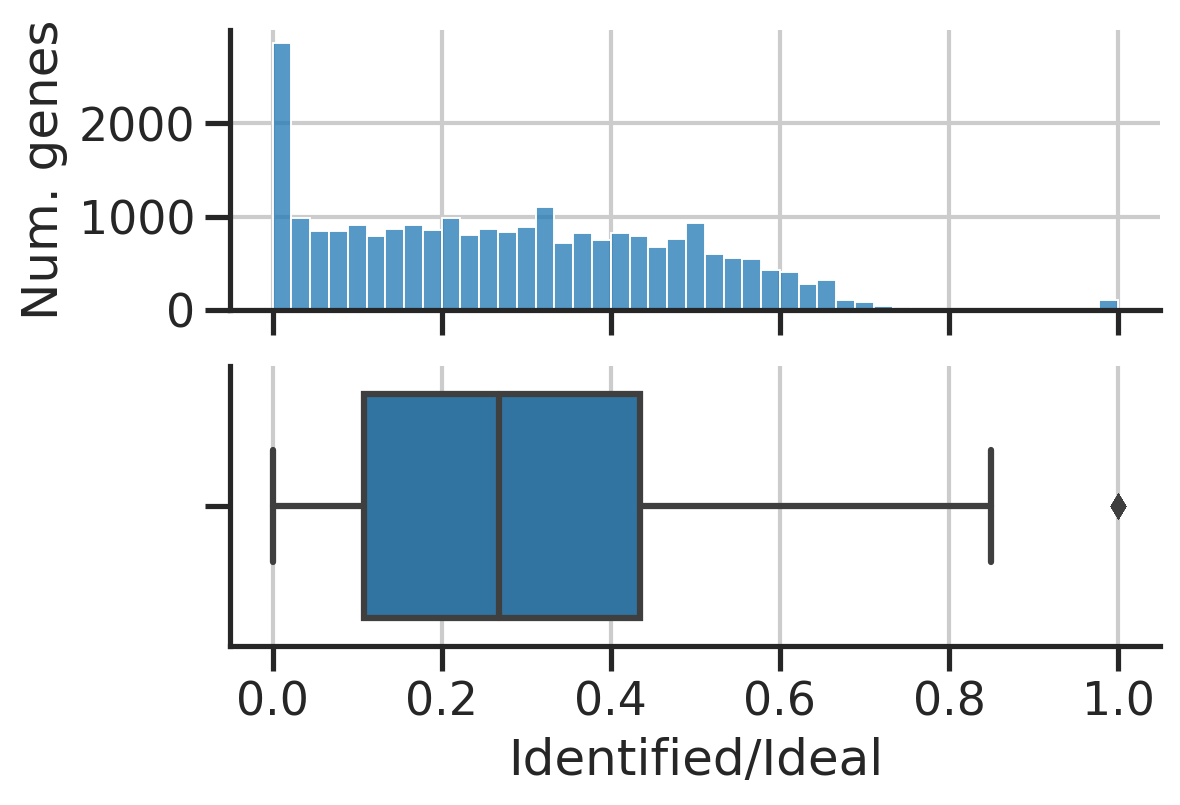

In [17]:
fig, axs = plt.subplots(2,1,figsize=(1*6,2*2), sharex=True)
ax = axs[0]
sns.histplot(resall[1]/resall['num30mer'], ax=ax)
ax.set_ylabel('Num. genes')
sns.despine(ax=ax)
ax = axs[1]
sns.boxplot(resall[1]/resall['num30mer'],  ax=ax)
ax.set_xlabel('Identified/Ideal')
sns.despine(ax=ax)

In [18]:
def panels2(_x, _y, xlabel='ctrl', ylabel='case'):
    """
    """
    fig = plt.figure(figsize=(12,6))
    axd = fig.subplot_mosaic("""AB
                                AC""")

    ax = axd['A']
    ax.scatter(_x, _y, s=1)
    ax.plot([1,100], [1,100], '--k', zorder=0)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax = axd['B']
    sns.histplot(_y/_x, ax=ax)
    ax.set_ylabel('Num. genes')
    sns.despine(ax=ax)

    ax = axd['C']
    sns.boxplot(_y/_x,  ax=ax)
    ax.set_xlabel(f'{ylabel}/{xlabel}')
    sns.despine(ax=ax)

    fig.tight_layout()
    plt.show()

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


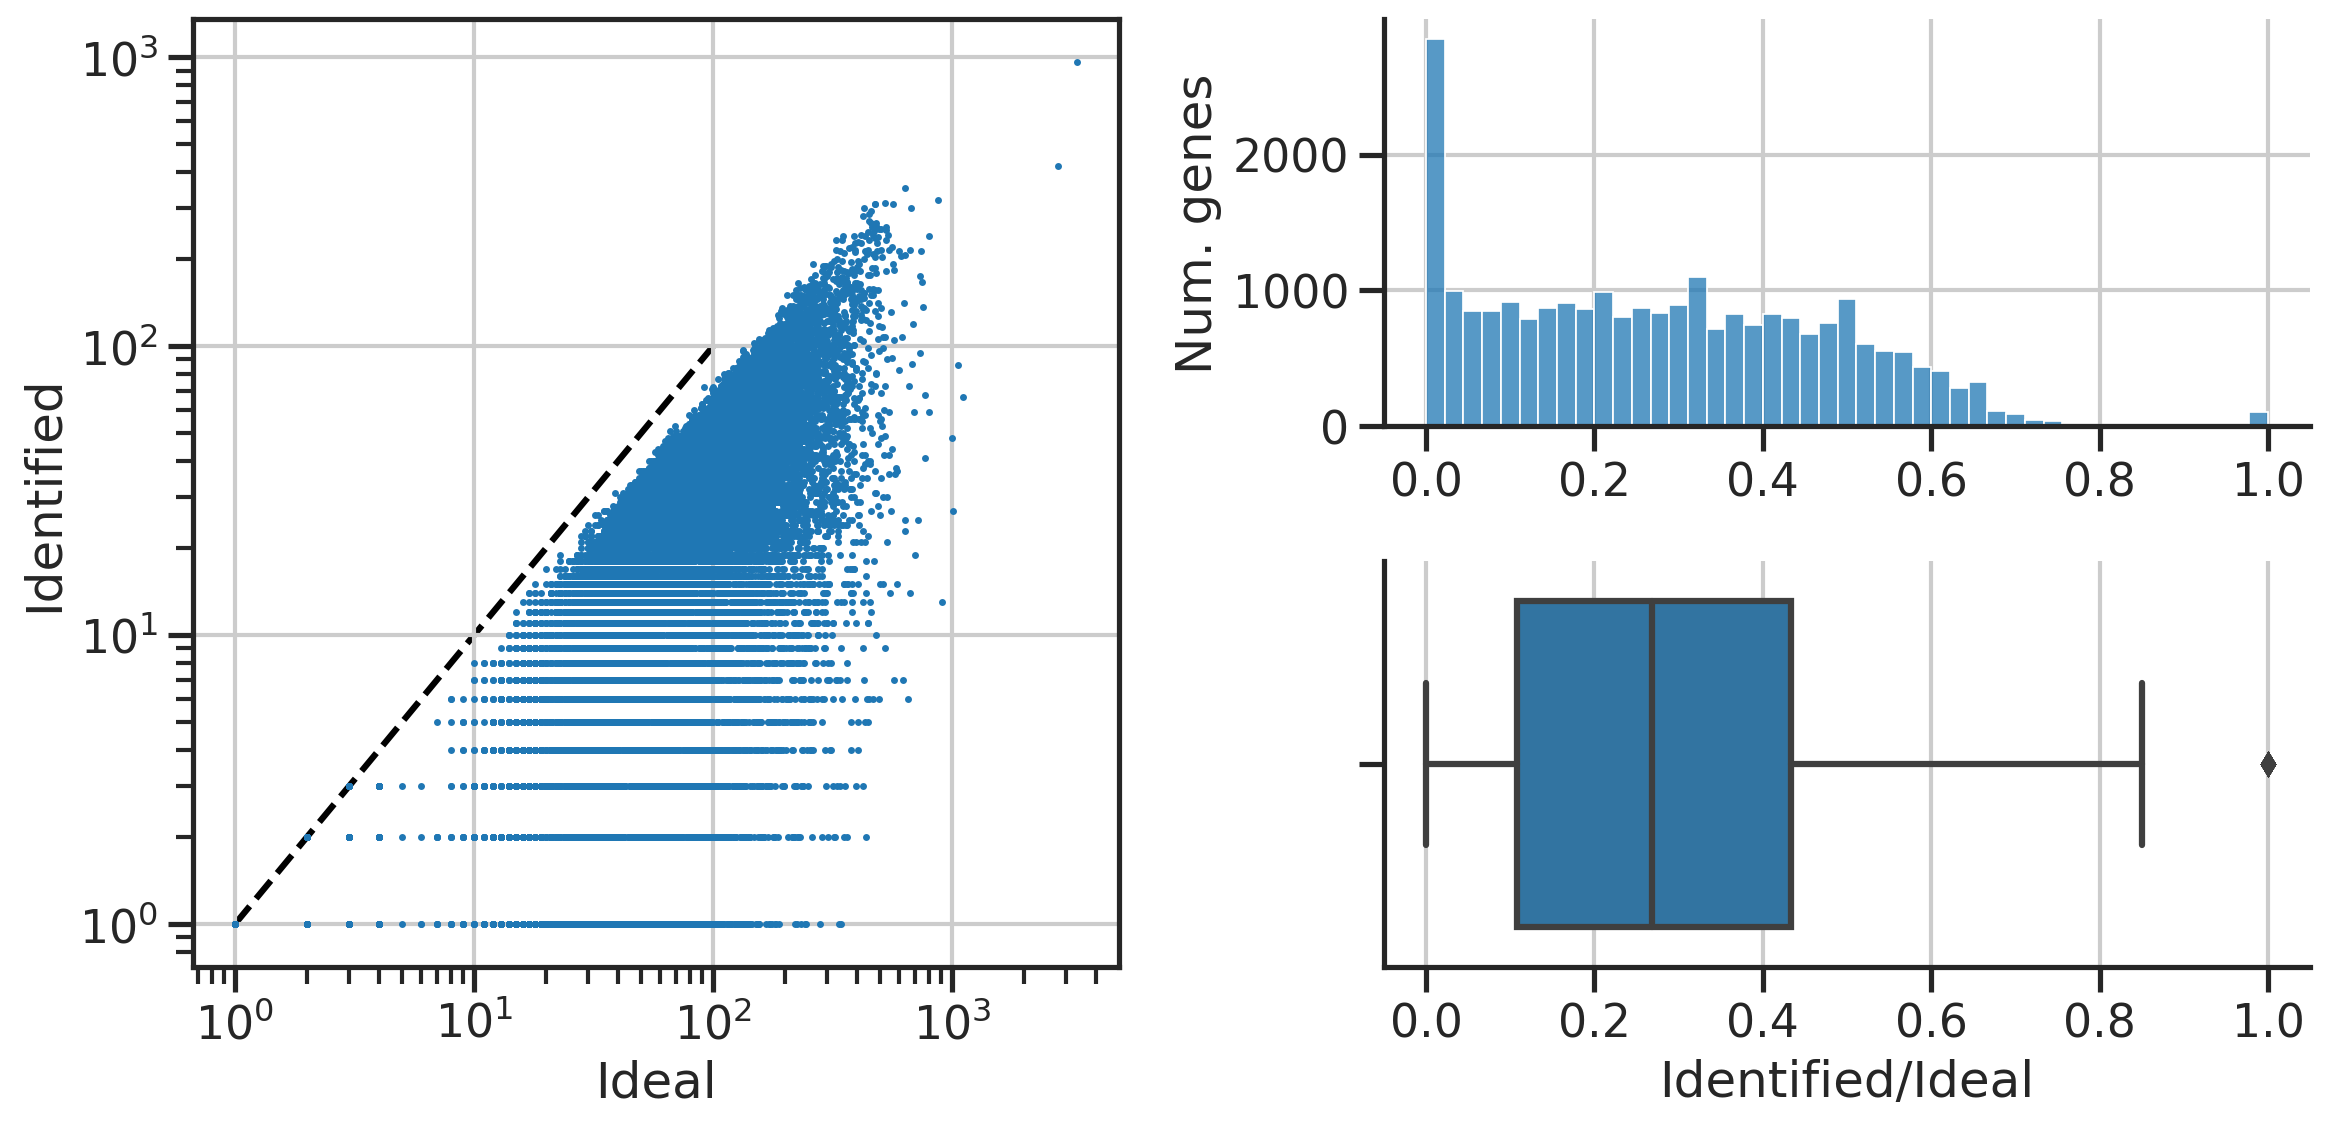

In [19]:
_x = resall['num30mer']
_y = resall[1]
panels2(_x, _y, xlabel='Ideal', ylabel='Identified')

# get PaintSHOP default; get old

In [20]:
# f = "/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Design/paintshop/data/mm10_isoflat_counts.csv"
f = "/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Design/paintshop/data/mm10_isoflat_counts_filtered_Oct26.csv"
dft = pd.read_csv(f, header=None, index_col=0)[1]
dft

0
0610005C13Rik     22
0610009B22Rik      8
0610009E02Rik      9
0610009L18Rik     10
0610010F05Rik     21
                ... 
Zyx               33
Zzef1            214
Zzz3              55
a                 10
ccdc198           19
Name: 1, Length: 23378, dtype: int64

In [21]:
resall = (upp.join(cnstrnts).join(dft.to_frame('default'))).fillna(0).astype(int)
resall

,len,num30mer,num30mer_cont,0,1,default
gene,,,,,,
0610005C13Rik,1122,34,37,17,16,22
0610009B22Rik,795,25,26,6,5,8
0610009E02Rik,1974,63,65,7,7,9
0610009L18Rik,619,20,20,10,10,10
0610010F05Rik,5020,156,167,11,11,21
...,...,...,...,...,...,...
Zyx,4504,144,150,37,31,33
Zzef1,11150,346,371,190,169,214
Zzz3,7909,255,263,54,27,55


/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


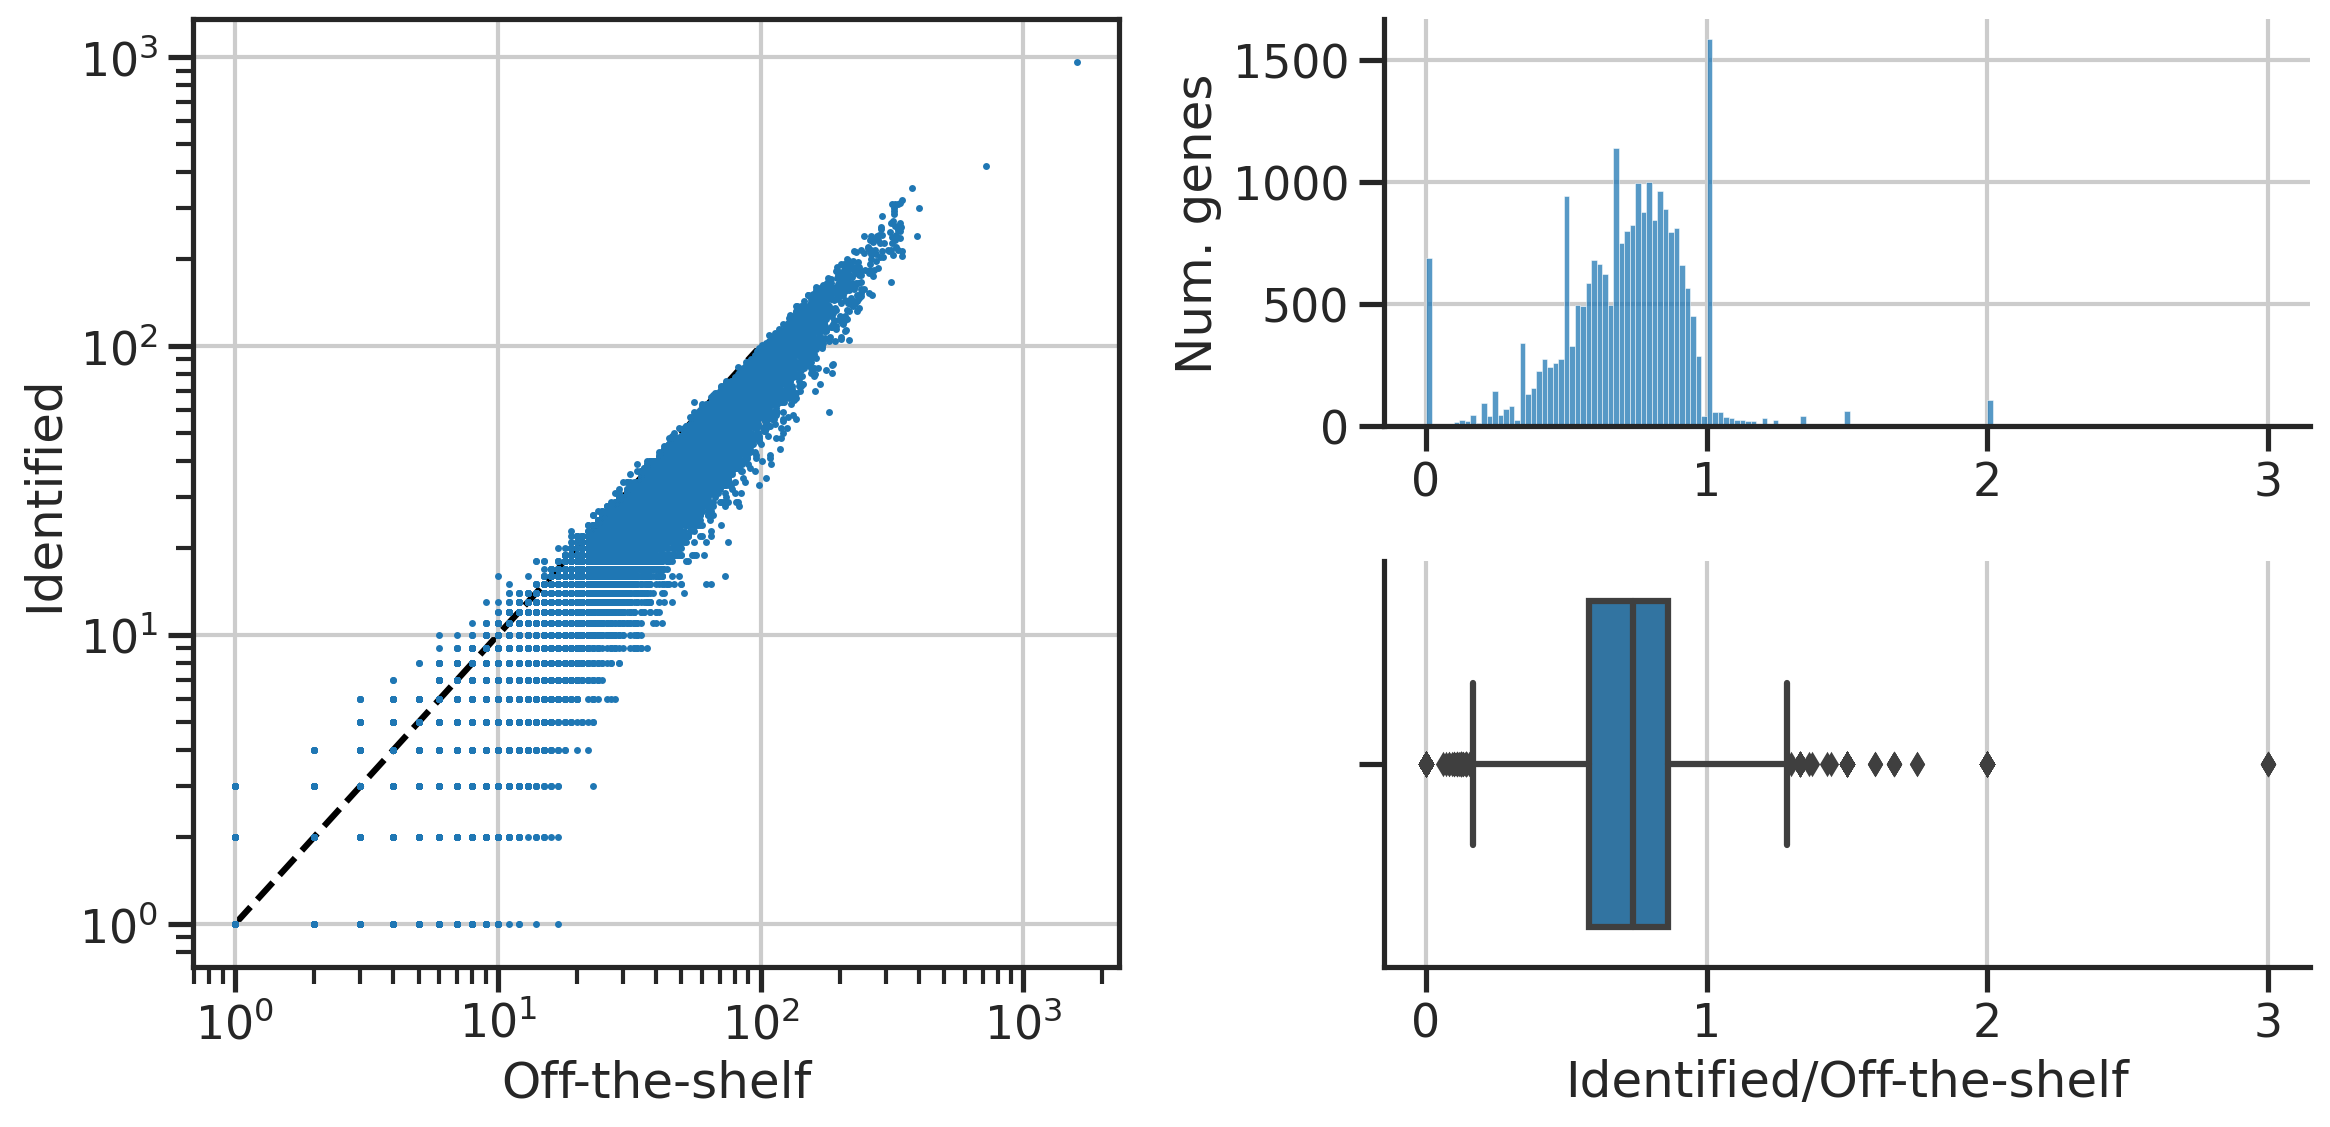

In [22]:
_x = resall['default']
_y = resall[1]
panels2(_x, _y, xlabel='Off-the-shelf', ylabel='Identified')

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


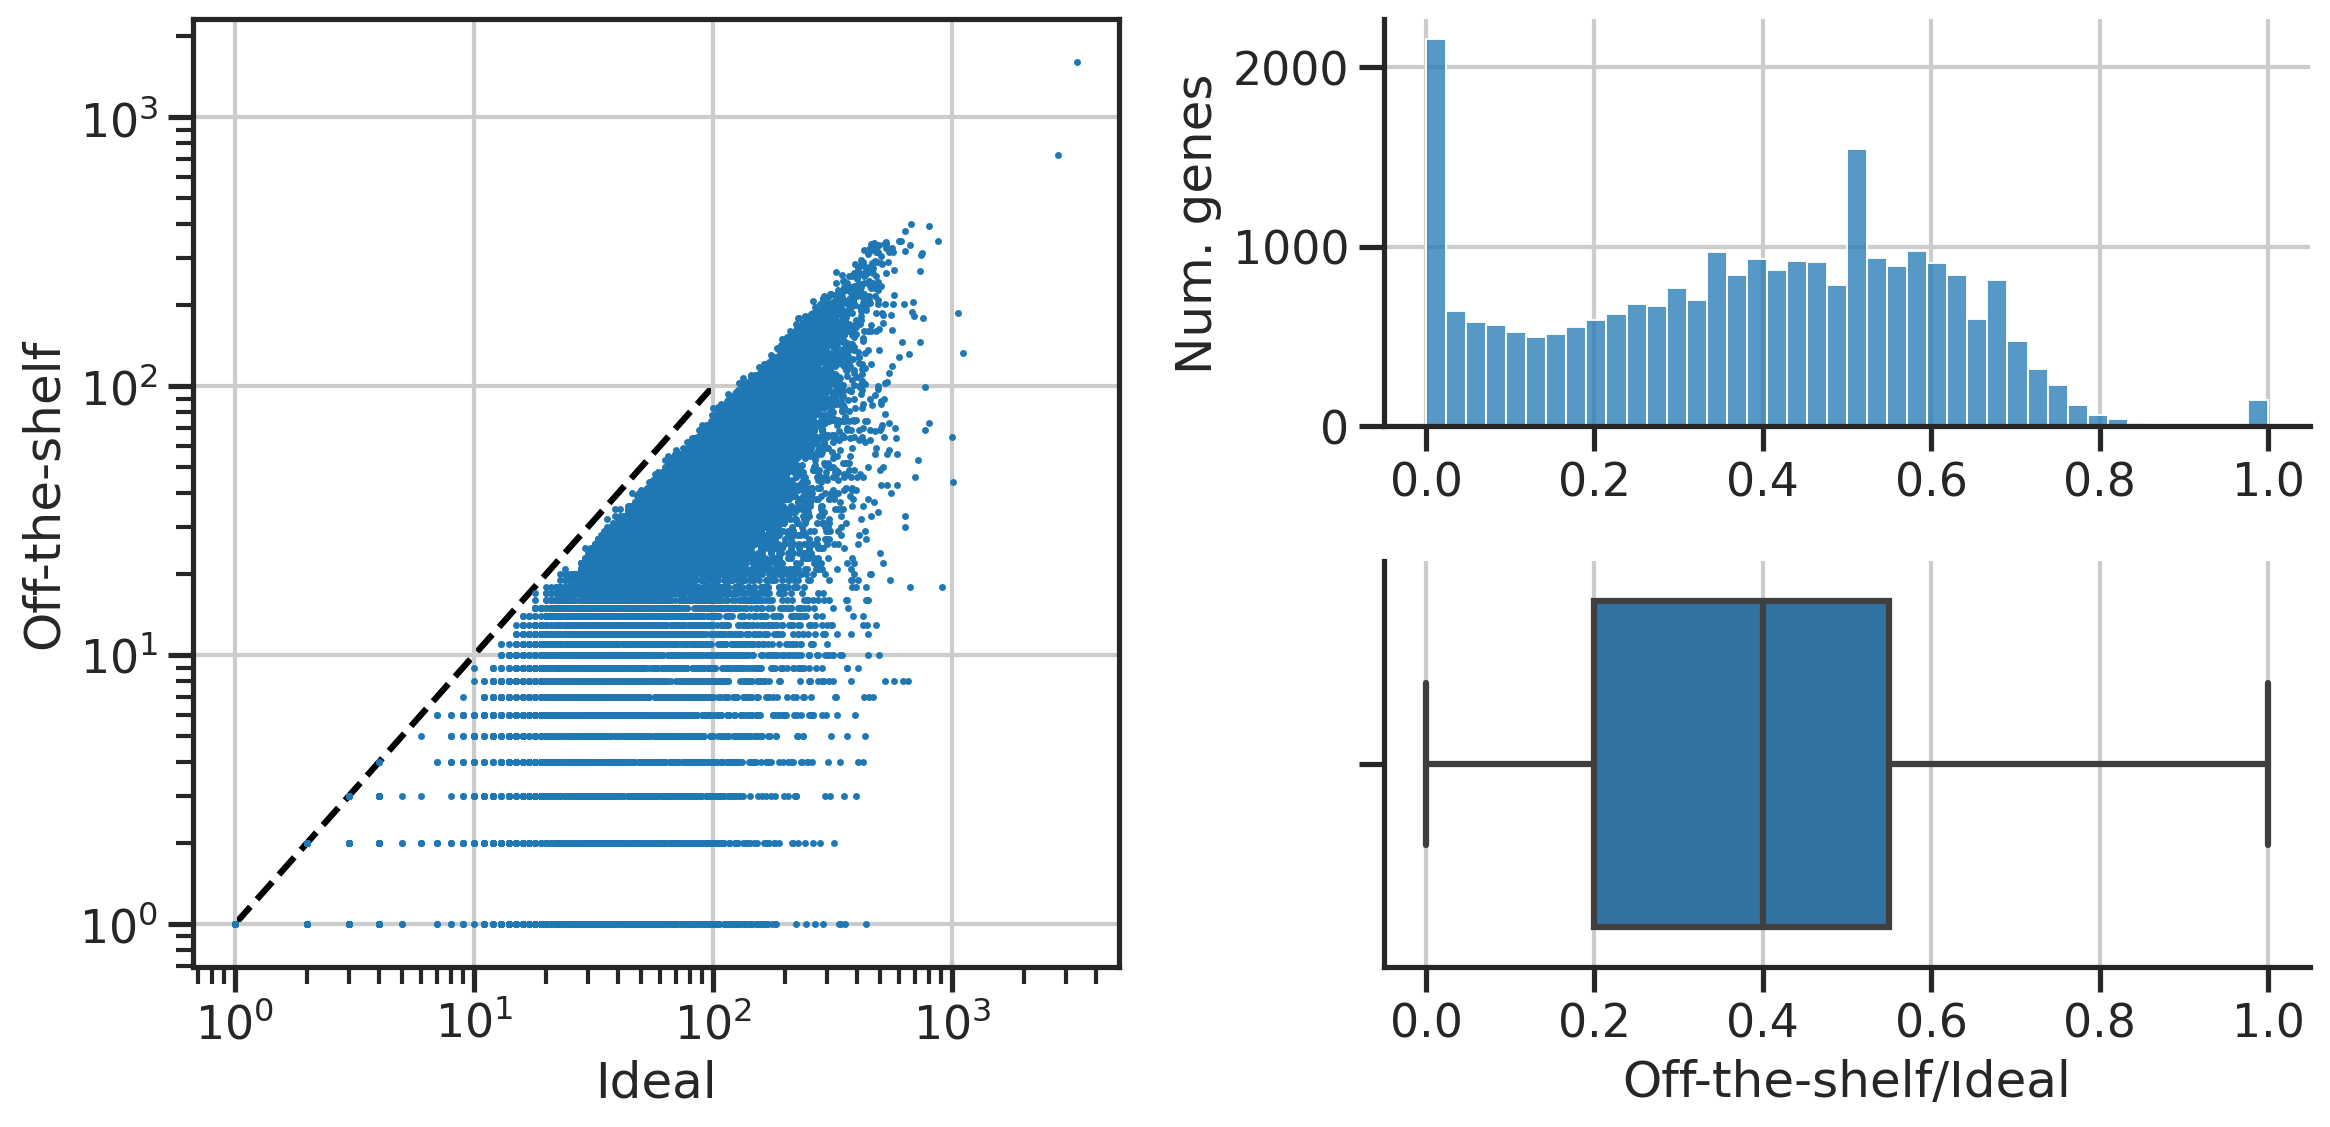

In [23]:
_x = resall['num30mer']
_y = resall['default']
panels2(_x, _y, xlabel='Ideal', ylabel='Off-the-shelf')

# save results of this code:
- filtered sequences 
- counts per gene (can be easily generated)

In [29]:
dfnew2

,chrom,start,end,seq,tm,onscore,offscore,repeat,prob,maxkmer,strand,gname,transcripts,len,gc
1,chr1,3214634,3214663,AGCTGATGGAGTGGTAAGCCCTCAAGCAGT,42.83,98.987,0.0,0,0.279,0,+,Xkr4,1,30,0.533333
2,chr1,3214882,3214911,ATTTGGCACTCGAAAGATGTGGCACGTGGT,42.67,100.000,0.0,0,0.192,0,+,Xkr4,1,30,0.500000
3,chr1,3214924,3214953,ACCTGCTGACCCATGTCATTCTGCACCTGG,43.76,100.000,0.0,0,0.277,2,+,Xkr4,1,30,0.566667
7,chr1,3215772,3215801,TCCTCCAGTGAATGTGCCCCAAATCTCTGC,42.11,100.000,0.0,0,0.342,2,+,Xkr4,1,30,0.533333
8,chr1,3215852,3215881,TCAGCACTGCTGGCTTGAATAGACACCAGC,42.33,97.718,0.0,0,0.171,0,+,Xkr4,1,30,0.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861045,chrY,2663406,2663435,TCTGTGACACTTTAGCCCTCCGATGAGGCT,42.35,99.945,0.0,0,0.204,0,+,Sry,1,30,0.533333
861046,chrY,2663509,2663538,TTCGGCTTCTGTAAGGCTTTTCCACCTGCA,42.15,100.000,0.0,0,0.285,2,+,Sry,1,30,0.500000
861047,chrY,2663561,2663590,GTATTTTGCATGCTGGGATTCTGCTGGGCC,42.06,100.000,0.0,0,0.407,3,+,Sry,1,30,0.533333
861048,chrY,2663591,2663620,AACTTGTGCCTCTCACCACGGGACCACACC,45.20,100.000,0.0,0,0.253,2,+,Sry,1,30,0.600000


In [25]:
output = '../paintshop/data/paintshop_pipe/mm10_dafault_30bp_Oct26.csv'
# dfnew2.to_csv(output, header=True, index=False)

In [28]:
# !chmod 444 $output
# !head $output

In [33]:
output = '../paintshop/data/paintshop_pipe/mm10_dafault_30bp_countspergene_Oct26.csv'
# dfnew2.groupby('gname').size().to_frame('counts').to_csv(output)

In [34]:
# !chmod 444 $output
# !head $output

gname,counts
0610005C13Rik,16
0610009B22Rik,5
0610009E02Rik,7
0610009L18Rik,10
0610010F05Rik,11
0610010K14Rik,12
0610012G03Rik,13
0610030E20Rik,41
0610031O16Rik,6
